# **PushBlockEnv Reinforcement Learning**

In [1]:
ENV_PATH = "../../../envs/PushBlock"

### **Imports**

In [44]:
### Utility
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

### Torch
import torch
from torch import nn
from torch import optim
### Torch RL
# Env
from torchrl.envs.libs import UnityMLAgentsEnv
from mlagents_envs.side_channel.engine_configuration_channel import EngineConfigurationChannel
from torchrl.envs.utils import step_mdp, check_env_specs
from torchrl.envs import TransformedEnv, Stack, ExcludeTransform, CatTensors, AutoResetTransform

# Data Collection
from torchrl.collectors import SyncDataCollector, MultiSyncDataCollector
from torchrl.data import LazyTensorStorage, ReplayBuffer
from torchrl.data.replay_buffers.samplers import SamplerWithoutReplacement


# Model
from model import create_policy, create_value
# Train Util
from train_util import make_loss_module, compute_trajectory_metrics, loss_dict, Stopwatch, Logger, Checkpointer, compute_single_trajectory_metrics, load_model
# Inspect Results
from result import plot, play, test

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using Device: {device}")

Using Device: cpu


## **Create Torch Env**

In [76]:
class SoftResetUnityEnv(UnityMLAgentsEnv):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self._did_first_reset = False
        self._last_base_td = None  # cache in base (group_*/agent_*) layout

    def _step(self, tensordict):
        # Cache the base-layout input td so soft resets can back-fill missing agents
        self._last_base_td = tensordict
        return super()._step(tensordict)

    def _reset(self, tensordict=None, **kwargs):
        hard = kwargs.pop("hard", False)
        if hard or not self._did_first_reset:
            # Real Unity reset
            td = super()._reset(tensordict, **kwargs)
            self._did_first_reset = True
            self._last_base_td = td  # keep a base-layout snapshot
            return td

        # Soft reset: DON'T touch Unity. Give base td to back-fill all agents.
        base_td = self._last_base_td
        if base_td is None or ("agents" in base_td.keys(True)):  # safety
            base_td = None
        return self._make_td_out(base_td, is_reset=True)


def create_unity_env(graphics=False, **kwargs):
    try:
        env.close()
    except:
        pass
    
    env = TransformedEnv(SoftResetUnityEnv(
        file_name=ENV_PATH, worker_id=np.random.randint(10000), 
        no_graphics=(not graphics), **kwargs,
        device="cpu",
    ))

    return env

def batch_agents(env, out_key="agents"):
    agent_root_key = env.observation_keys[0][0]
    agents = list(env.action_spec[agent_root_key].keys())
    
    # Create transform
    stack = Stack(
        in_keys=[(agent_root_key, agent) for agent in agents], 
        out_key=(out_key,), 
        in_key_inv=(out_key,), 
        out_keys_inv=[(agent_root_key, agent) for agent in agents]
    )

    env.append_transform(stack)
    return env

def create_base_env(graphics=False, **kwargs):
    env = create_unity_env(graphics, **kwargs)

    # Batch into Agents Dimension
    env = batch_agents(env)

    # Concatenate Observation
    obs_keys = env.observation_keys
    env.append_transform(
        CatTensors(in_keys=obs_keys, out_key=("agents", "observation"), del_keys=False)
    )
    # Exclude Group Reward
    env.append_transform(
        ExcludeTransform(("agents", "group_reward"))
    )
    return env

def create_env(graphics=False, time_scale = 1, **kwargs):
    # Time scale
    if time_scale != 1:
        engine_config_channel = EngineConfigurationChannel()
        env = create_base_env(graphics, **kwargs, side_channels=[engine_config_channel])
        engine_config_channel.set_configuration_parameters(time_scale=time_scale)
    else:
        env = create_base_env(graphics, **kwargs)

    return env

### **Inspect Specs**

In [77]:
def print_specs(env):
    print("action_spec:", env.action_spec)
    print("reward_spec:", env.reward_spec)
    print("done_spec:", env.done_spec)
    print("observation_spec:", env.observation_spec)

env = create_env(time_scale=20)
check_env_specs(env)
print_specs(env)

[UnityMemory] Configuration Parameters - Can be set up in boot.config
    "memorysetup-bucket-allocator-granularity=16"
    "memorysetup-bucket-allocator-bucket-count=8"
    "memorysetup-bucket-allocator-block-size=4194304"
    "memorysetup-bucket-allocator-block-count=1"
    "memorysetup-main-allocator-block-size=16777216"
    "memorysetup-thread-allocator-block-size=16777216"
    "memorysetup-gfx-main-allocator-block-size=16777216"
    "memorysetup-gfx-thread-allocator-block-size=16777216"
    "memorysetup-cache-allocator-block-size=4194304"
    "memorysetup-typetree-allocator-block-size=2097152"
    "memorysetup-profiler-bucket-allocator-granularity=16"
    "memorysetup-profiler-bucket-allocator-bucket-count=8"
    "memorysetup-profiler-bucket-allocator-block-size=4194304"
    "memorysetup-profiler-bucket-allocator-block-count=1"
    "memorysetup-profiler-allocator-block-size=16777216"
    "memorysetup-profiler-editor-allocator-block-size=1048576"
    "memorysetup-temp-allocator-siz

In [78]:
action_key = env.action_key[1]
print(f"action_key: {action_key}")

observation_shape = env.observation_spec["agents", "observation"].shape
action_shape = env.action_spec["agents", action_key].shape

print(f"observation_shape: {observation_shape}, action_shape: {action_shape}")

action_key: discrete_action
observation_shape: torch.Size([32, 210]), action_shape: torch.Size([32, 7])


In [79]:
td = env.rollout(1000)
td

TensorDict(
    fields={
        agents: TensorDict(
            fields={
                StackingSensor_size3_OffsetRayPerceptionSensor: Tensor(shape=torch.Size([258, 32, 105]), device=cpu, dtype=torch.float32, is_shared=False),
                StackingSensor_size3_RayPerceptionSensor: Tensor(shape=torch.Size([258, 32, 105]), device=cpu, dtype=torch.float32, is_shared=False),
                discrete_action: Tensor(shape=torch.Size([258, 32, 7]), device=cpu, dtype=torch.int32, is_shared=False),
                done: Tensor(shape=torch.Size([258, 32, 1]), device=cpu, dtype=torch.bool, is_shared=False),
                observation: Tensor(shape=torch.Size([258, 32, 210]), device=cpu, dtype=torch.float32, is_shared=False),
                terminated: Tensor(shape=torch.Size([258, 32, 1]), device=cpu, dtype=torch.bool, is_shared=False),
                truncated: Tensor(shape=torch.Size([258, 32, 1]), device=cpu, dtype=torch.bool, is_shared=False)},
            batch_size=torch.Size([258,

### **Inspect Action Space**

We have categorical actions: 7 choices (choose one).

In [80]:
actions_df = pd.DataFrame({
    "action": td["agents", action_key].reshape(-1)
})
actions_df.describe()

,action
count,57792.000000
mean,0.142857
std,0.349930
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


### **Inspect Observation Space**

Observations consist of binary features and continuous features scaled to the range [0, 1].

In [81]:
obs_df = pd.DataFrame({
    "obs": td["agents", "observation"].reshape(-1)
})
obs_df.describe()

,obs
count,1.733760e+06
mean,3.418947e-01
std,4.551491e-01
min,0.000000e+00
25%,0.000000e+00
50%,0.000000e+00
75%,1.000000e+00
max,1.000000e+00


### **Inspect Reward Space**
-0.001 for surviving, +1 on success.

In [82]:
reward_df = pd.DataFrame({
    "reward": td["next", "agents", "reward"].reshape(-1),
})
reward_df.describe()

,reward
count,8256.000000
mean,-0.000391
std,0.055033
min,-0.001000
25%,-0.001000
50%,-0.001000
75%,-0.001000
max,4.999400


## **Create Models**

### **Config**

In [83]:
HIDDEN_DIM = 256
N_BLOCKS = 3

MODEL_CONFIG = {
    "hidden_dim": HIDDEN_DIM,
    "n_blocks": N_BLOCKS,
    "in_features": int(observation_shape[1]),
    "out_features": int(action_shape[1]),
}
MODEL_CONFIG

{'hidden_dim': 256, 'n_blocks': 3, 'in_features': 210, 'out_features': 7}

### **Inspect**

In [84]:
policy, value = create_policy(MODEL_CONFIG).to(device), create_value(MODEL_CONFIG).to(device)
loss_module = make_loss_module(policy, value, epsilon=0.1, entropy_coef=0.01, gamma=0.99, lmbda=0.95).to(device)

with torch.no_grad():
    td = env.rollout(10, policy=policy, auto_cast_to_device=True).to(device)
    loss_module.value_estimator(td)
data = step_mdp(td)["agents"]
data

TensorDict(
    fields={
        StackingSensor_size3_OffsetRayPerceptionSensor: Tensor(shape=torch.Size([10, 32, 105]), device=cpu, dtype=torch.float32, is_shared=False),
        StackingSensor_size3_RayPerceptionSensor: Tensor(shape=torch.Size([10, 32, 105]), device=cpu, dtype=torch.float32, is_shared=False),
        advantage: Tensor(shape=torch.Size([10, 32, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        discrete_action: Tensor(shape=torch.Size([10, 32, 7]), device=cpu, dtype=torch.float32, is_shared=False),
        done: Tensor(shape=torch.Size([10, 32, 1]), device=cpu, dtype=torch.bool, is_shared=False),
        log_prob: Tensor(shape=torch.Size([10, 32]), device=cpu, dtype=torch.float32, is_shared=False),
        logits: Tensor(shape=torch.Size([10, 32, 7]), device=cpu, dtype=torch.float32, is_shared=False),
        observation: Tensor(shape=torch.Size([10, 32, 210]), device=cpu, dtype=torch.float32, is_shared=False),
        reward: Tensor(shape=torch.Size([10,

In [85]:
compute_single_trajectory_metrics(td)

{'return': -0.009981251321732998,
 'episode_length': 10.0,
 'entropy': 1.811618447303772}

## **Training**

### **Train Config**

In [86]:
device_type = "cuda" if str(device).startswith("cuda") else "cpu"
amp_dtype   = torch.float16 if device_type == "cuda" else torch.float32

### Training Loop Params
WORKERS = 1 # os.cpu_count() // 2
print("device:", device, "workers:", WORKERS)
STORAGE_DEVICE = device
GENERATION_SIZE = 1000 * WORKERS # 1000 is the truncation point for the env
TIMESTAMPS = GENERATION_SIZE * 50
EPOCHS = 5

# GD Params
MINIBATCH_SIZE = 64
LR = 5e-5
MAX_GRAD_NORM = 0.5

### RL Params

# ENV Params
TIME_SCALE = 20

# PPO Params
GAMMA = 0.99
GAE_LAMBDA = 0.95
EPSILON = 0.2
ENTROPY_COEF = 1e-5

LOG_KEYS = [
    "generation", "time", "collection_time", "train_time",  # Training Progress Metrics
    "return", "episode_length",                             # Performance Metrics
    "entropy",                                              # Exploration Metrics
    "policy_loss", "kl_approx", "clip_fraction", "ESS",     # Policy Metrics
    "value_loss", "explained_variance",                     # Value Metrics
]

LOG_PATH = 'logs'
CKPT_PATH = 'ckpt'
MODEL_PATH = 'models'
NAME = 'run0'

LOG_INTERVAL = 1
CHECKPOINT_INTERVAL = 1
METRIC_KEY = "return"

CONTINUE=False

device: cpu workers: 1


### **Train Loop**

In [87]:
def train(create_env, policy, value, timestamps=TIMESTAMPS):
    # Loss + Optimizer
    loss_module = make_loss_module(policy, value, epsilon=EPSILON, entropy_coef=ENTROPY_COEF, gamma=GAMMA, lmbda=GAE_LAMBDA)
    optimizer = optim.Adam(loss_module.parameters(), lr=LR)
    # only need scaler with float16, float32 and bfloat16 have wider exponent ranges.
    scaler = torch.amp.GradScaler(enabled=(amp_dtype == torch.float16))

    # Logger + Checkpointer
    logger = Logger(keys = LOG_KEYS, log_path=LOG_PATH, name=NAME)
    checkpointer = Checkpointer(ckpt_path=CKPT_PATH, name=NAME)
    

    # Continue/Reset
    start_generation = 0
    if not CONTINUE:
        logger.reset()
        checkpointer.reset()
    else:
        checkpoint = checkpointer.load_progress()
        if checkpoint:
            start_generation = int(checkpoint["generation"])
            policy.load_state_dict(checkpoint["policy_state_dict"])
            value.load_state_dict(checkpoint["value_state_dict"])
            optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
            if "scaler_state_dict" in checkpoint:
                scaler.load_state_dict(checkpoint["scaler_state_dict"])
            print("CHECKPOINT FOUND, STARTING FROM GENERATION:", start_generation)
        else:
            print("CHECKPOINT NOT FOUND, STARTING FROM SCRATCH")

    # Watches
    short_watch = Stopwatch()
    long_watch = Stopwatch()

    if WORKERS > 1:
        collector = MultiSyncDataCollector([create_env]*WORKERS, policy, 
            frames_per_batch=GENERATION_SIZE, 
            total_frames=timestamps - GENERATION_SIZE*start_generation, 
            env_device="cpu", device=device, storing_device=STORAGE_DEVICE, 
            update_at_each_batch=True,
        )
    else:
        collector = SyncDataCollector(
            create_env, policy, 
            frames_per_batch=GENERATION_SIZE, 
            total_frames=timestamps - GENERATION_SIZE*start_generation, 
            env_device="cpu", device=device, storing_device=STORAGE_DEVICE,
        )
    replay_buffer = ReplayBuffer(storage=LazyTensorStorage(GENERATION_SIZE, device=STORAGE_DEVICE), sampler=SamplerWithoutReplacement(), batch_size=MINIBATCH_SIZE)


    ### TRAINING LOOP
    short_watch.start(); long_watch.start()
    policy.eval(); value.eval()
    for i, tensordict_data in enumerate(collector):
        # 0. Time collect
        collection_time = short_watch.end()
        logger.sum({"collection_time": collection_time})

        # 1. Compute Advantages and Value Target and Metrics
        tensordict_data = tensordict_data.to(device)
        with torch.no_grad():
            loss_module.value_estimator(tensordict_data)
            metrics = compute_trajectory_metrics(tensordict_data)
        logger.add(metrics)

        # 2. Minibatch Gradient Descent Loop
        short_watch.start()
        policy.train(); value.train()
        replay_buffer.empty(); replay_buffer.extend(tensordict_data.reshape(-1))
        for epoch in range(EPOCHS):
            for j, batch in enumerate(replay_buffer):
                # 2.1 Optimization Step
                batch = batch.to(device)
                with torch.autocast(device_type=device_type, dtype=amp_dtype, enabled=(amp_dtype==torch.float16)):
                    loss_data = loss_module(batch)
                    loss = loss_data["loss_objective"] + loss_data["loss_critic"] + loss_data["loss_entropy"]
                optimizer.zero_grad(set_to_none=True)
                scaler.scale(loss).backward()

                scaler.unscale_(optimizer)
                nn.utils.clip_grad_norm_(loss_module.parameters(), max_norm=MAX_GRAD_NORM)

                scaler.step(optimizer)
                scaler.update()

                # 2.2 Accumulate Metric
                weight = float(batch.batch_size[0])
                logger.accumulate(loss_dict(loss_data, weight))
        policy.eval(); value.eval()
        train_time = short_watch.end()
        logger.sum({"train_time": train_time})

        # 3. Log results
        logger.sum({"generation": 1})
        if (i % LOG_INTERVAL) == 0:
            logger.sum({"time": long_watch.end()})
            long_watch.start()
            logger.next(print_row=True)
        # 4. Checkpoint model
        if (i % CHECKPOINT_INTERVAL) == 0:
            gen = int(start_generation + i + 1)
            metric = metrics[METRIC_KEY]
            checkpointer.save_progress(metric_key=METRIC_KEY,
            state_obj={
                "generation": gen,
                "policy_state_dict": policy.state_dict(),
                "value_state_dict": value.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "scaler_state_dict": scaler.state_dict(),
                METRIC_KEY: metric,
            })

        # 5. Start collection time
        short_watch.start()

    checkpointer.copy_model('latest', MODEL_PATH, ('policy_state_dict', 'value_state_dict'))
    return logger.dataframe()

In [ ]:
policy = create_policy(MODEL_CONFIG).to(device)
value = create_value(MODEL_CONFIG).to(device)

train(lambda: create_env(time_scale=TIME_SCALE), policy, value, timestamps=TIMESTAMPS)

[UnityMemory] Configuration Parameters - Can be set up in boot.config
    "memorysetup-bucket-allocator-granularity=16"
    "memorysetup-bucket-allocator-bucket-count=8"
    "memorysetup-bucket-allocator-block-size=4194304"
    "memorysetup-bucket-allocator-block-count=1"
    "memorysetup-main-allocator-block-size=16777216"
    "memorysetup-thread-allocator-block-size=16777216"
    "memorysetup-gfx-main-allocator-block-size=16777216"
    "memorysetup-gfx-thread-allocator-block-size=16777216"
    "memorysetup-cache-allocator-block-size=4194304"
    "memorysetup-typetree-allocator-block-size=2097152"
    "memorysetup-profiler-bucket-allocator-granularity=16"
    "memorysetup-profiler-bucket-allocator-bucket-count=8"
    "memorysetup-profiler-bucket-allocator-block-size=4194304"
    "memorysetup-profiler-bucket-allocator-block-count=1"
    "memorysetup-profiler-allocator-block-size=16777216"
    "memorysetup-profiler-editor-allocator-block-size=1048576"
    "memorysetup-temp-allocator-siz

/opt/homebrew/anaconda3/envs/mlagents3/lib/python3.10/site-packages/torchrl/envs/libs/unity_mlagents.py:373: DeprecationWarning: In future, it will be an error for 'np.bool' scalars to be interpreted as an index
  source[group_name][agent_name]["truncated"] = torch.tensor(


   generation       time  collection_time  train_time    return  \
0           1  33.017256        26.817278     5.77802 -0.008357   

   episode_length   entropy  policy_loss  kl_approx  clip_fraction       ESS  \
0      142.857147  1.834194     -0.06947    0.00798       0.192314  0.977513   

   value_loss  explained_variance  
0    0.017854            0.468456  


/opt/homebrew/anaconda3/envs/mlagents3/lib/python3.10/site-packages/torchrl/envs/libs/unity_mlagents.py:373: DeprecationWarning: In future, it will be an error for 'np.bool' scalars to be interpreted as an index
  source[group_name][agent_name]["truncated"] = torch.tensor(


   generation       time  collection_time  train_time  return  episode_length  \
1           2  66.291761        54.022332   11.472997 -0.1245           125.0   

    entropy  policy_loss  kl_approx  clip_fraction       ESS  value_loss  \
1  1.805482    -0.026504   0.010116       0.205763  0.976435    0.001226   

   explained_variance  
1             0.51003  


/opt/homebrew/anaconda3/envs/mlagents3/lib/python3.10/site-packages/torchrl/envs/libs/unity_mlagents.py:373: DeprecationWarning: In future, it will be an error for 'np.bool' scalars to be interpreted as an index
  source[group_name][agent_name]["truncated"] = torch.tensor(


   generation       time  collection_time  train_time    return  \
2           3  99.523081        80.879445   17.482866 -0.093194   

   episode_length   entropy  policy_loss  kl_approx  clip_fraction       ESS  \
2      111.111115  1.762078    -0.019129   0.006962        0.13982  0.980568   

   value_loss  explained_variance  
2    0.002175            0.207497  


/opt/homebrew/anaconda3/envs/mlagents3/lib/python3.10/site-packages/torchrl/envs/libs/unity_mlagents.py:373: DeprecationWarning: In future, it will be an error for 'np.bool' scalars to be interpreted as an index
  source[group_name][agent_name]["truncated"] = torch.tensor(


   generation        time  collection_time  train_time    return  \
3           4  133.129989       108.273188   23.298253 -0.093306   

   episode_length  entropy  policy_loss  kl_approx  clip_fraction       ESS  \
3      111.111115  1.70426    -0.011693   0.007225       0.149762  0.980684   

   value_loss  explained_variance  
3    0.000974           -2.569031  


/opt/homebrew/anaconda3/envs/mlagents3/lib/python3.10/site-packages/torchrl/envs/libs/unity_mlagents.py:373: DeprecationWarning: In future, it will be an error for 'np.bool' scalars to be interpreted as an index
  source[group_name][agent_name]["truncated"] = torch.tensor(


   generation        time  collection_time  train_time    return  \
4           5  166.529815       135.395353   29.170462 -0.061955   

   episode_length   entropy  policy_loss  kl_approx  clip_fraction       ESS  \
4       90.909088  1.611868    -0.010504   0.004648       0.075253  0.987625   

   value_loss  explained_variance  
4    0.002821          -16.457839  


/opt/homebrew/anaconda3/envs/mlagents3/lib/python3.10/site-packages/torchrl/envs/libs/unity_mlagents.py:373: DeprecationWarning: In future, it will be an error for 'np.bool' scalars to be interpreted as an index
  source[group_name][agent_name]["truncated"] = torch.tensor(


   generation        time  collection_time  train_time   return  \
5           6  199.915061       162.599241   34.970381 -0.07625   

   episode_length   entropy  policy_loss  kl_approx  clip_fraction       ESS  \
5       90.909088  1.518625    -0.005004   0.002596       0.029761  0.991829   

   value_loss  explained_variance  
5    0.000854          -15.695455  


/opt/homebrew/anaconda3/envs/mlagents3/lib/python3.10/site-packages/torchrl/envs/libs/unity_mlagents.py:373: DeprecationWarning: In future, it will be an error for 'np.bool' scalars to be interpreted as an index
  source[group_name][agent_name]["truncated"] = torch.tensor(


   generation        time  collection_time  train_time    return  \
6           7  233.623949       189.926122   40.952593 -0.069896   

   episode_length   entropy  policy_loss  kl_approx  clip_fraction       ESS  \
6       83.333336  1.488182    -0.005386   0.002723       0.032006  0.990969   

   value_loss  explained_variance  
6    0.001027          -22.457264  


/opt/homebrew/anaconda3/envs/mlagents3/lib/python3.10/site-packages/torchrl/envs/libs/unity_mlagents.py:373: DeprecationWarning: In future, it will be an error for 'np.bool' scalars to be interpreted as an index
  source[group_name][agent_name]["truncated"] = torch.tensor(


   generation      time  collection_time  train_time    return  \
7           8  267.6825       217.411855   47.112897 -0.034883   

   episode_length   entropy  policy_loss  kl_approx  clip_fraction       ESS  \
7       66.666664  1.502421    -0.009636   0.012572       0.172488  0.976182   

   value_loss  explained_variance  
7    0.004921          -45.400715  


/opt/homebrew/anaconda3/envs/mlagents3/lib/python3.10/site-packages/torchrl/envs/libs/unity_mlagents.py:373: DeprecationWarning: In future, it will be an error for 'np.bool' scalars to be interpreted as an index
  source[group_name][agent_name]["truncated"] = torch.tensor(


   generation        time  collection_time  train_time    return  \
8           9  301.248565       244.546921   53.126106 -0.021412   

   episode_length   entropy  policy_loss  kl_approx  clip_fraction       ESS  \
8       58.823528  1.426739    -0.012013   0.009162       0.130182  0.982485   

   value_loss  explained_variance  
8    0.004239          -15.351177  


/opt/homebrew/anaconda3/envs/mlagents3/lib/python3.10/site-packages/torchrl/envs/libs/unity_mlagents.py:373: DeprecationWarning: In future, it will be an error for 'np.bool' scalars to be interpreted as an index
  source[group_name][agent_name]["truncated"] = torch.tensor(


   generation        time  collection_time  train_time   return  \
9          10  334.708977       271.627047   59.113414 -0.01815   

   episode_length   entropy  policy_loss  kl_approx  clip_fraction       ESS  \
9            50.0  1.412719    -0.012051   0.015568       0.215119  0.972063   

   value_loss  explained_variance  
9    0.005641            -8.81275  


/opt/homebrew/anaconda3/envs/mlagents3/lib/python3.10/site-packages/torchrl/envs/libs/unity_mlagents.py:373: DeprecationWarning: In future, it will be an error for 'np.bool' scalars to be interpreted as an index
  source[group_name][agent_name]["truncated"] = torch.tensor(


    generation        time  collection_time  train_time    return  \
10          11  368.586491       298.932061   65.291115 -0.027329   

    episode_length   entropy  policy_loss  kl_approx  clip_fraction       ESS  \
10        52.63158  1.248344    -0.006142   0.007986       0.085767  0.987709   

    value_loss  explained_variance  
10    0.001047           -4.572028  


/opt/homebrew/anaconda3/envs/mlagents3/lib/python3.10/site-packages/torchrl/envs/libs/unity_mlagents.py:373: DeprecationWarning: In future, it will be an error for 'np.bool' scalars to be interpreted as an index
  source[group_name][agent_name]["truncated"] = torch.tensor(


    generation       time  collection_time  train_time    return  \
11          12  402.31616       326.000834   71.561656 -0.009398   

    episode_length   entropy  policy_loss  kl_approx  clip_fraction       ESS  \
11       45.454544  1.277289    -0.009994     0.0153       0.182357  0.963812   

    value_loss  explained_variance  
11    0.003643           -8.782248  


/opt/homebrew/anaconda3/envs/mlagents3/lib/python3.10/site-packages/torchrl/envs/libs/unity_mlagents.py:373: DeprecationWarning: In future, it will be an error for 'np.bool' scalars to be interpreted as an index
  source[group_name][agent_name]["truncated"] = torch.tensor(


    generation        time  collection_time  train_time    return  \
12          13  435.826243       353.014132   77.669575 -0.013846   

    episode_length   entropy  policy_loss  kl_approx  clip_fraction       ESS  \
12        38.46154  1.348043    -0.008302   0.018454       0.243874  0.965207   

    value_loss  explained_variance  
12    0.004161           -5.330587  


/opt/homebrew/anaconda3/envs/mlagents3/lib/python3.10/site-packages/torchrl/envs/libs/unity_mlagents.py:373: DeprecationWarning: In future, it will be an error for 'np.bool' scalars to be interpreted as an index
  source[group_name][agent_name]["truncated"] = torch.tensor(


    generation        time  collection_time  train_time   return  \
13          14  471.416288       380.598058   85.154713 -0.01448   

    episode_length   entropy  policy_loss  kl_approx  clip_fraction       ESS  \
13            40.0  1.229066    -0.007296   0.018295       0.234439  0.967936   

    value_loss  explained_variance  
13    0.006141          -16.856128  


/opt/homebrew/anaconda3/envs/mlagents3/lib/python3.10/site-packages/torchrl/envs/libs/unity_mlagents.py:373: DeprecationWarning: In future, it will be an error for 'np.bool' scalars to be interpreted as an index
  source[group_name][agent_name]["truncated"] = torch.tensor(


    generation        time  collection_time  train_time    return  \
14          15  506.674451       409.181889   91.401783 -0.001661   

    episode_length   entropy  policy_loss  kl_approx  clip_fraction       ESS  \
14       35.714287  1.138695    -0.011373   0.013953       0.154618  0.973697   

    value_loss  explained_variance  
14    0.006176           -3.929789  


/opt/homebrew/anaconda3/envs/mlagents3/lib/python3.10/site-packages/torchrl/envs/libs/unity_mlagents.py:373: DeprecationWarning: In future, it will be an error for 'np.bool' scalars to be interpreted as an index
  source[group_name][agent_name]["truncated"] = torch.tensor(


    generation        time  collection_time  train_time    return  \
15          16  541.532628        437.01908   97.970811  0.014664   

    episode_length  entropy  policy_loss  kl_approx  clip_fraction       ESS  \
15       34.482758  1.11896    -0.008781   0.015029       0.173321  0.973254   

    value_loss  explained_variance  
15    0.009906           -11.73376  


/opt/homebrew/anaconda3/envs/mlagents3/lib/python3.10/site-packages/torchrl/envs/libs/unity_mlagents.py:373: DeprecationWarning: In future, it will be an error for 'np.bool' scalars to be interpreted as an index
  source[group_name][agent_name]["truncated"] = torch.tensor(


    generation        time  collection_time  train_time    return  \
16          17  576.951212       465.466618  104.479622  0.017742   

    episode_length  entropy  policy_loss  kl_approx  clip_fraction       ESS  \
16        30.30303  1.24025     -0.00593   0.020724       0.190583  0.956487   

    value_loss  explained_variance  
16     0.01133           -1.583725  


/opt/homebrew/anaconda3/envs/mlagents3/lib/python3.10/site-packages/torchrl/envs/libs/unity_mlagents.py:373: DeprecationWarning: In future, it will be an error for 'np.bool' scalars to be interpreted as an index
  source[group_name][agent_name]["truncated"] = torch.tensor(


    generation        time  collection_time  train_time    return  \
17          18  612.117842       493.370473  111.222173  0.041055   

    episode_length   entropy  policy_loss  kl_approx  clip_fraction      ESS  \
17       24.390244  1.349433    -0.023668   0.017501       0.231385  0.96311   

    value_loss  explained_variance  
17    0.013703           -1.670021  


/opt/homebrew/anaconda3/envs/mlagents3/lib/python3.10/site-packages/torchrl/envs/libs/unity_mlagents.py:373: DeprecationWarning: In future, it will be an error for 'np.bool' scalars to be interpreted as an index
  source[group_name][agent_name]["truncated"] = torch.tensor(


    generation       time  collection_time  train_time    return  \
18          19  647.25739       521.212733  118.046576  0.019173   

    episode_length   entropy  policy_loss  kl_approx  clip_fraction       ESS  \
18       25.641026  1.356445     -0.00776   0.018412       0.204985  0.966145   

    value_loss  explained_variance  
18    0.013415           -2.293791  


/opt/homebrew/anaconda3/envs/mlagents3/lib/python3.10/site-packages/torchrl/envs/libs/unity_mlagents.py:373: DeprecationWarning: In future, it will be an error for 'np.bool' scalars to be interpreted as an index
  source[group_name][agent_name]["truncated"] = torch.tensor(


    generation        time  collection_time  train_time    return  \
19          20  683.362172        549.91476  124.989061  0.036745   

    episode_length   entropy  policy_loss  kl_approx  clip_fraction       ESS  \
19        21.73913  1.412297    -0.027452   0.014961       0.226914  0.965629   

    value_loss  explained_variance  
19    0.017189           -1.678661  


/opt/homebrew/anaconda3/envs/mlagents3/lib/python3.10/site-packages/torchrl/envs/libs/unity_mlagents.py:373: DeprecationWarning: In future, it will be an error for 'np.bool' scalars to be interpreted as an index
  source[group_name][agent_name]["truncated"] = torch.tensor(


    generation        time  collection_time  train_time    return  \
20          21  718.434459       578.000895  131.532437  0.059702   

    episode_length   entropy  policy_loss  kl_approx  clip_fraction       ESS  \
20        19.23077  1.411976    -0.041362   0.017876       0.283335  0.957919   

    value_loss  explained_variance  
20    0.025923           -0.928199  


/opt/homebrew/anaconda3/envs/mlagents3/lib/python3.10/site-packages/torchrl/envs/libs/unity_mlagents.py:373: DeprecationWarning: In future, it will be an error for 'np.bool' scalars to be interpreted as an index
  source[group_name][agent_name]["truncated"] = torch.tensor(


    generation        time  collection_time  train_time    return  \
21          22  755.467566        606.70544  139.339741  0.053692   

    episode_length   entropy  policy_loss  kl_approx  clip_fraction       ESS  \
21        19.23077  1.355404    -0.023524   0.020948       0.249776  0.961413   

    value_loss  explained_variance  
21    0.027915           -0.213301  


/opt/homebrew/anaconda3/envs/mlagents3/lib/python3.10/site-packages/torchrl/envs/libs/unity_mlagents.py:373: DeprecationWarning: In future, it will be an error for 'np.bool' scalars to be interpreted as an index
  source[group_name][agent_name]["truncated"] = torch.tensor(


## **Test**

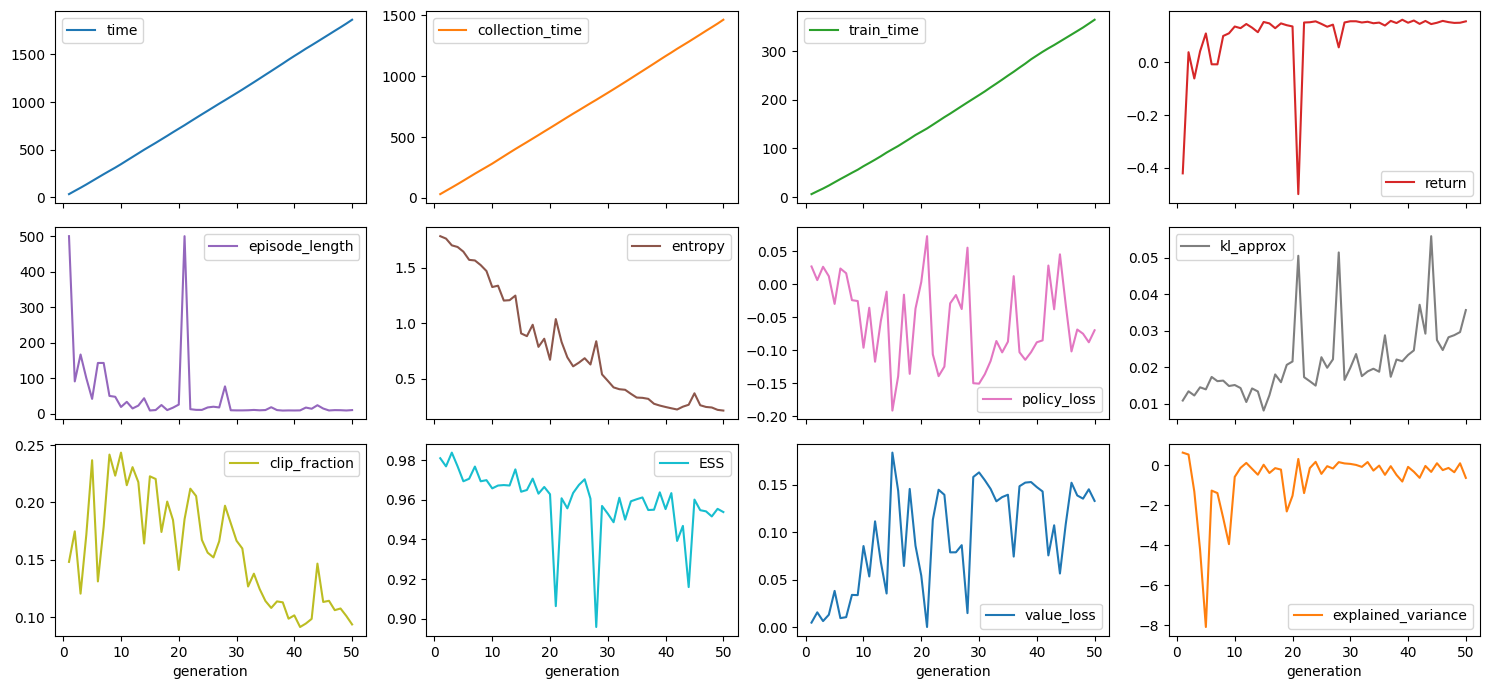

In [4]:
plot(NAME)

In [52]:
policy = create_policy(MODEL_CONFIG).to(device)
load_model(MODEL_PATH, NAME, policy, None)

In [55]:
env = create_env(graphics=True)

tensordict_data = None
with torch.no_grad():
    tensordict_data = env.rollout(1000, policy=policy, auto_cast_to_device=True).to(device)
    env.close()
    metrics = compute_single_trajectory_metrics(tensordict_data)

metrics

[UnityMemory] Configuration Parameters - Can be set up in boot.config
    "memorysetup-bucket-allocator-granularity=16"
    "memorysetup-bucket-allocator-bucket-count=8"
    "memorysetup-bucket-allocator-block-size=4194304"
    "memorysetup-bucket-allocator-block-count=1"
    "memorysetup-main-allocator-block-size=16777216"
    "memorysetup-thread-allocator-block-size=16777216"
    "memorysetup-gfx-main-allocator-block-size=16777216"
    "memorysetup-gfx-thread-allocator-block-size=16777216"
    "memorysetup-cache-allocator-block-size=4194304"
    "memorysetup-typetree-allocator-block-size=2097152"
    "memorysetup-profiler-bucket-allocator-granularity=16"
    "memorysetup-profiler-bucket-allocator-bucket-count=8"
    "memorysetup-profiler-bucket-allocator-block-size=4194304"
    "memorysetup-profiler-bucket-allocator-block-count=1"
    "memorysetup-profiler-allocator-block-size=16777216"
    "memorysetup-profiler-editor-allocator-block-size=1048576"
    "memorysetup-temp-allocator-siz

TypeError: Can't instantiate abstract class FakeResetWrapper with abstract methods _build_env, _check_kwargs, _init_env, _make_specs, _set_seed, _step

In [34]:
tensordict_data

TensorDict(
    fields={
        agents: LazyStackedTensorDict(
            fields={
                StackingSensor_size3_OffsetRayPerceptionSensor: Tensor(shape=torch.Size([1000, 32, 105]), device=cpu, dtype=torch.float32, is_shared=False),
                StackingSensor_size3_RayPerceptionSensor: Tensor(shape=torch.Size([1000, 32, 105]), device=cpu, dtype=torch.float32, is_shared=False),
                discrete_action: Tensor(shape=torch.Size([1000, 32, 7]), device=cpu, dtype=torch.float32, is_shared=False),
                done: Tensor(shape=torch.Size([1000, 32, 1]), device=cpu, dtype=torch.bool, is_shared=False),
                log_prob: Tensor(shape=torch.Size([1000, 32]), device=cpu, dtype=torch.float32, is_shared=False),
                logits: Tensor(shape=torch.Size([1000, 32, 7]), device=cpu, dtype=torch.float32, is_shared=False),
                observation: Tensor(shape=torch.Size([1000, 32, 210]), device=cpu, dtype=torch.float32, is_shared=False),
                termin

In [36]:
tensordict_data["next", "agents", "done"].sum()

tensor(3)